# **前日の20:00までのデータを用いて翌日の00:00~23:50までの日射量を予測する**

### **必要な関数・ライブラリ**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [5]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [6]:
def get_chunked_data(x, chunk_size):
    '''
    rnnに突っ込むためのchunk_sizeごとに区切った系列データを作る
    '''
    input_list = []
    for i in range(0, len(x) - chunk_size + 1):
        input_list.append(x[i : i + chunk_size])
    input_list = np.array(input_list)
    return input_list

In [7]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [8]:
def calc_mse(X, Y):
    '''
    X, Yがでかすぎるのでnp系が使えない
    '''
    mse = 0
    for i in range(len(X)):
        mse += (X[i]- Y[i]) ** 2
    return mse/len(X)

In [9]:
def calc_mae(X, Y):
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

In [65]:
def get_30(tmp_data):
    '''
    必要なカラムだけ拾ってきて30分ごのデータに整形
    '''
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

### **データの準備**

In [74]:
# 予測する発電所番号を決める
target_place = 1
chunk_size = 24
model_name = "model_"+str(target_place)+'_chunk_'+str(chunk_size)
try:
    os.mkdir('./data/'+model_name)
except:
    print("file exists")

file exists


In [75]:
# アメダスデータの読み込み

if target_place == 1 or target_place == 2:
    # 横浜アメダスのデータを使って予測する, amd_46106
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    amd_data.head()
elif target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    amd_data.head()
else:
    raise ValueError("invalid input target_place_num")

In [76]:
amd_data = get_30(amd_data)

In [77]:
# モデル構築のためにデータを分割する

# 日射量の欠損値を一つ前の値で置換/output_data
key = "sl"
amd_data[key] = amd_data[key].fillna(method='bfill')

# 学習に必要なデータ
# 144ステップ分のデータで次ステップを予測する
train_x_s_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-01 00:30')].index[0]
train_x_e_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 23:00')].index[0]
train_y_s_idx = train_x_s_idx + chunk_size
train_y_e_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

output_tp = amd_data[[key]][train_y_s_idx:train_y_e_idx+1]
input_tp = amd_data[[key]][train_x_s_idx:train_x_e_idx+1]

# 予測に必要なデータ
# 144ステップ分のデータで次の予測をする
test_y_s_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 00:00')].index[0]
test_y_e_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2017-3-31 23:30')].index[0]
test_x_s_idx = test_y_s_idx - chunk_size
test_x_e_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2017-3-31 23:00')].index[0]

test_input_tp = amd_data[[key]][test_x_s_idx:test_x_e_idx+1]
test_output_tp = amd_data[[key]][test_y_s_idx:test_y_e_idx+1]

In [78]:
# rnnに突っ込むための準備

# rnnに突っ込むためにmin-max正規化しておく
normalized_input = (input_tp - input_tp.min()) / (input_tp.max() - input_tp.min())
normalized_input = np.array(normalized_input)
normalized_output = (output_tp - output_tp.min()) / (output_tp.max() - output_tp.min())
normalized_output = np.array(normalized_output)

# 時系列データのリストにする
input_list = get_chunked_data(normalized_input, chunk_size)

# testデータの入力を用意
normalized_test_input = (test_input_tp - test_input_tp.min()) / (test_input_tp.max() - test_input_tp.min())
normalized_test_input = np.array(normalized_test_input)
test_input_list = get_chunked_data(normalized_test_input, chunk_size)

# denormalize用
output_max = float(input_tp.max())
output_min = float(input_tp.min())

# RNNに突っ込むためにデータを整形
X = np.array(input_list).reshape(len(input_list), chunk_size, input_list.shape[2])
Y = np.array(normalized_output).reshape(len(input_list), 1)
X_predict = np.array(test_input_list).reshape(len(test_input_list), chunk_size, test_input_list.shape[2])

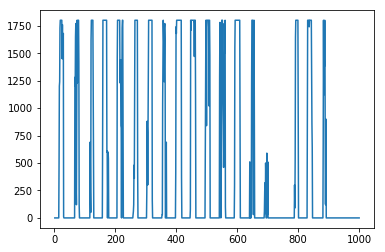

In [79]:
plt.plot(input_tp[key][0:1000])

### **モデルの構築**

条件:翌日の気温を予測するには前日の20:00までの気象情報しか使えない

モデル：8/17の00:00 ~ 23:50までのデータを予測するとき

8/15 20:10 ~ 8/16 20:00のデータから8/16の20:10のデータを

8/15 20:20 ~ 8/16 20:10のデータから8/16の20:20のデータを

....

8/16 23:50 ~ 8/17 23:40のデータから8/17の23:50のデータを予測する


In [80]:
# 今までLSTMやってたからとりあえずLSTMでやってみる

class simpleLSTM:
    def __init__(self, X, Y, epochs = 1000, batch_size = 150, model_name = "test_model"):
        # 学習データと検証用データに分けておく
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.1)))
        self.X = X # 入力
        self.Y = Y # 教師
        self.X_val = X_val # 検証用
        self.Y_val = Y_val #検証用
        
        '''
        諸変数の設定
        '''
        self.input_layer_size = self.X.shape[2] #入力層の数
        self.hidden_layer_size = 1 # 隠れ層の数、適当
        self.output_layer_size = 1 #出力層の数、求める値は時間あたりの発電量の値1つなので1
        self.batch_size = batch_size #バッチサイズ、適当
        self.chunk_size = self.X.shape[1] # 一回の系列データの長さ
        self.learning_rate = 0.01 # 学習率 適当
        self.forget_bias = 0.9  # 忘却率
        self.epochs = epochs #エポック数
        
        # 学習データの保存
        self.model_name = str(model_name)
        
        
    def shuffle(self):
        '''
        ミニバッチかする際にランダムにシャッフル
        '''
        idx = [i for i in range(self.X.shape[0])]
        np.random.shuffle(idx)
        xs = np.array([[y for y in list(self.X[r])] for r in idx])
        ys = np.array([self.Y[r] for r in idx])
        return xs, ys
        
    def inference(self, input_ph, inistate_ph):
        '''
        グラフの構築
        '''
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01), name='hidden_w')
        hidden_b = tf.Variable(tf.truncated_normal([self.hidden_layer_size]), name='hidden_b')
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01), name='output_w')
        output_b = tf.Variable(tf.truncated_normal([self.output_layer_size]), name='output_b')
        
        #　input_phの整型  
        in1 = tf.transpose(input_ph, [1, 0, 2]) 
        in2 = tf.reshape(in1, [-1, self.input_layer_size]) 
        in3 = tf.matmul(in2, hidden_w) + hidden_b
        in4 = tf.split(in3, self.chunk_size, 0)
          
        # BasicLSTMCellを定義
        cell = tf.contrib.rnn.BasicLSTMCell(self.hidden_layer_size, forget_bias=self.forget_bias, state_is_tuple=False)
        rnn_outputs, states = tf.contrib.rnn.static_rnn(cell, in4, initial_state=inistate_ph)
        output = tf.matmul(rnn_outputs[-1], output_w) + output_b
        results = [hidden_w, output_w, hidden_w, hidden_b]
        return output, states, results
        
    def loss(self, output_ph, actual_ph):
        '''
        お題と同じmean absolute errorを仕様
        '''
        cost = tf.reduce_mean(tf.abs((output_ph - actual_ph)))
        tf.summary.scalar('loss', cost)
        return cost
    
    def training(self, cost):
        '''
        adamを仕様beta1, beta2は元論文の推奨値を仕様
        '''
        with tf.name_scope("training") as scope:
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999).minimize(cost)
            return optimizer
    
    def train(self):
        '''
        学習
        '''
        random.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)
        n_batch = self.X.shape[0] // self.batch_size
        
        with tf.Graph().as_default():
            # 変数の用意
            input_ph = tf.placeholder('float', [None, self.chunk_size, self.input_layer_size], name='input')
            actual_ph = tf.placeholder('float', [None, self.output_layer_size], name='actual_value')
            inistate_ph = tf.placeholder('float', [None, self.hidden_layer_size * 2], name='inistate')

            prediction, state, weights = self.inference(input_ph, inistate_ph)
            cost = self.loss(prediction, actual_ph)
            optimizer = self.training(cost)

            # TensorBoardで可視化する
            summary = tf.summary.merge_all()
            # 初期化
            init = tf.global_variables_initializer()
                
            # ここから学習
            with tf.Session() as sess:
                # 学習したモデルも保存しておく
                saver = tf.train.Saver()
                summary_writer = tf.summary.FileWriter("/tmp/tensorflow_log", graph=sess.graph)
                sess.run(init)

                for epoch in range(self.epochs):
                    X_, Y_ = self.shuffle()
                    for i in range(n_batch):
                        start = i * self.batch_size
                        end = start + self.batch_size
                        inputs  = X_[start:end]
                        actuals = Y_[start:end]
                        train_dict = {
                            input_ph:      inputs,
                            actual_ph:     actuals,
                            inistate_ph:     np.zeros((self.batch_size, self.hidden_layer_size * 2)),
                        }
                    
                    sess.run(optimizer, feed_dict=train_dict)

                    if (epoch) % (self.epochs//10) == 0:
                        val_dict = {
                            input_ph:      self.X_val,
                            actual_ph:     self.Y_val,
                            inistate_ph:     np.zeros((self.X_val.shape[0], self.hidden_layer_size * 2)),
                        }
                        summary_str, train_loss = sess.run([summary, cost], feed_dict=val_dict)
                        print("train#%d, validation loss: %e" % (epoch, train_loss))
                        summary_writer.add_summary(summary_str, epoch)
                        
                    datas = sess.run(weights)
                    saver.save(sess,  "./data/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")
                    
                datas = sess.run(weights)
                saver.save(sess, "./data/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")
                
    def predict(self, X_predict, model_name = "test_model"):
        '''
        予測期間に該当するデータから予測
        '''
        # 予測に使う変数の用意
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.chunk_size, self.input_layer_size], name='input')
        inistate_ph = tf.placeholder("float", [None, self.hidden_layer_size * 2], name='inistate')
        prediction, state, weights = self.inference(input_ph, inistate_ph)
        pre_dict = {
            input_ph: X_predict,
            inistate_ph: np.zeros((X_predict.shape[0], self.hidden_layer_size*2))
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess,  "./data/" + str(self.model_name) + "/" + str(self.model_name) + ".ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)


        return expected_output

In [81]:
model_name = "sl_30_"+str(target_place)+'_chunk_'+str(chunk_size)
try:
    os.mkdir('./data/'+model_name)
    print("make save directory")
except:
    print("file exists")

make save directory


In [90]:
tp_lstm = simpleLSTM(X, Y, model_name = model_name, epochs=1000)

In [91]:
# tp_lstm.train()

train#0, validation loss: 2.477188e-01
train#100, validation loss: 2.374992e-01
train#200, validation loss: 7.910212e-02
train#300, validation loss: 5.877960e-02
train#400, validation loss: 6.172167e-02
train#500, validation loss: 5.510403e-02
train#600, validation loss: 5.527847e-02
train#700, validation loss: 5.542703e-02
train#800, validation loss: 5.470575e-02
train#900, validation loss: 5.568272e-02


In [93]:
batch_size = 10000
n_batch = len(test_input_list) // batch_size
processed_predict = np.array([])
for i in range(n_batch+1):
    s_idx = i * batch_size
    e_idx = (i+1) * batch_size
    if e_idx > len(test_input_list):
        e_idx = len(test_input_list)
    print("---- predict " + str(s_idx) + " ~ " + str(e_idx)+ " ----")
    predict = tp_lstm.predict(test_input_list[s_idx:e_idx], model_name)
    predict = np.array(predict).reshape(len(predict[0]))
    tmp_predict = denormalize_array(predict, output_min, output_max)
    processed_predict = np.r_[processed_predict, tmp_predict]

---- predict 0 ~ 10000 ----
---- predict 10000 ~ 20000 ----
---- predict 20000 ~ 21936 ----


In [94]:
calc_mae(processed_predict, np.array(test_output_tp))

array([ 112.0416049])

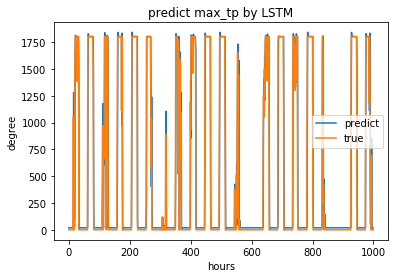

In [95]:
plt.plot(processed_predict[0:1000], label = "predict")
plt.plot(np.array(test_output_tp)[0:1000], label = "true")
# plt.ylim(0, 300)
plt.xlabel("hours")
plt.ylabel("degree")
plt.legend()
plt.title("predict max_tp by LSTM")

In [97]:
### 実際の予測の場合
processed_predict = np.array([])
tmp_input = test_input_list[0]
tmp_input = tmp_input.reshape(1, 24, 1)
predict = tp_lstm.predict(tmp_input, model_name)
predict = np.array(predict).reshape(len(predict[0]))
for i in range(56):
    tmp_input = np.append(tmp_input, predict)
    tmp_input = tmp_input[1:]
    tmp_input = tmp_input.reshape(1, 24, 1)
    predict = tp_lstm.predict(tmp_input, model_name)
    predict = np.array(predict).reshape(len(predict[0]))
    tmp_predict = denormalize_array(predict, output_min, output_max)
    processed_predict = np.r_[processed_predict, tmp_predict]

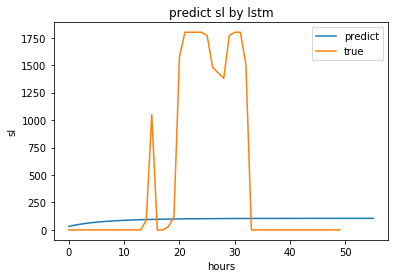

In [98]:
plt.plot(processed_predict, label="predict")
plt.plot(np.array(test_output_tp)[0:50], label = "true")
plt.xlabel("hours")
plt.ylabel("sl")
plt.title("predict sl by lstm")
plt.legend()

In [48]:
tmp_input

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [51]:
np.append(tmp_input, predict)[1:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00052392])